### This is a speech recognition script using tensorflow

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
import subprocess

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)




Manipulate the data so that NaN columns and "classes" that appear only once are dropped. Split the data into test and train sets.

In [4]:
data = pd.read_table("./Data/fin/cv-corpus-12.0-2022-12-07/fi/validated.tsv")
data.dropna(axis=1, inplace=True)
data.drop("down_votes",axis=1, inplace=True)
data.drop("locale",axis=1, inplace=True)
data.drop("up_votes",axis=1, inplace=True)
counts = data["client_id"].value_counts(ascending=True)
singles = counts.where(counts.values == 1).dropna(axis=0)
to_drop = singles.index

for id in to_drop:
    data = data[data.client_id != id]

all_classes = data.client_id.unique();


for idx, classname in enumerate(all_classes):
    data["client_id"] = data["client_id"].replace(classname, idx)

data.rename(columns = {"client_id": 'Class'}, inplace=True);

train, validation = train_test_split(data, test_size=0.2);

train_classes = train.Class.unique();
#ensure that the whole class-set is represented in the training data
while(train_classes.size<all_classes.size):
    train, validation = train_test_split(data, test_size=0.2);

    train_classes = train.Class.unique();

for c in train_classes:
    if(len(os.listdir(".\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\training_set\\")) == 0 and len(os.listdir(".\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\validation_set\\")) == 0):
        os.mkdir(".\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\training_set\\"+str(c))
        os.mkdir(".\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\validation_set\\"+str(c))
    else:
        continue


In [5]:

def mp3_to_wav(file):
    filename = pathlib.Path(file).stem
    if(not (train.path[train.path == filename+".mp3"].empty)):
        classname = str(train.Class[train.path == filename+".mp3"].item())
        output = ".\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\training_set\\"+classname+"\\"+filename+".wav"
        print(output)
        subprocess.call(["ffmpeg", "-i", file, output])
    if(not (validation.path[validation.path == filename+".mp3"].empty)):
        classname = str(validation.Class[validation.path == filename+".mp3"].item())
        output = ".\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\validation_set\\"+classname+"\\"+filename+".wav"
        print(output)
        subprocess.call(["ffmpeg", "-i", file, output])
    #sound = AudioSegment.from_mp3(file)
    #file = sound.export(filename, format="wav")


Transform the MP3-files into .wav format (set transform to __True__ if data is not transformed)
***

In [6]:

transform = True
i = 1
if(transform):
    directory = "./Data/fin/cv-corpus-12.0-2022-12-07/fi/clips/"
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if(os.path.isfile(f) and not (data.path[data.path == filename].empty)):
            i+=1
            print(i)
            mp3_to_wav(f)
            


2
.\Data\fin\cv-corpus-12.0-2022-12-07\fi\wavs\training_set\116\common_voice_fi_22986631.wav
3
.\Data\fin\cv-corpus-12.0-2022-12-07\fi\wavs\training_set\116\common_voice_fi_22986632.wav
4
.\Data\fin\cv-corpus-12.0-2022-12-07\fi\wavs\training_set\116\common_voice_fi_22986633.wav
5
.\Data\fin\cv-corpus-12.0-2022-12-07\fi\wavs\training_set\116\common_voice_fi_22986634.wav
6
.\Data\fin\cv-corpus-12.0-2022-12-07\fi\wavs\training_set\116\common_voice_fi_22986635.wav
7
.\Data\fin\cv-corpus-12.0-2022-12-07\fi\wavs\training_set\116\common_voice_fi_22987456.wav
8
.\Data\fin\cv-corpus-12.0-2022-12-07\fi\wavs\training_set\116\common_voice_fi_22987458.wav
9
.\Data\fin\cv-corpus-12.0-2022-12-07\fi\wavs\training_set\116\common_voice_fi_22987462.wav
10
.\Data\fin\cv-corpus-12.0-2022-12-07\fi\wavs\training_set\116\common_voice_fi_22987463.wav
11
.\Data\fin\cv-corpus-12.0-2022-12-07\fi\wavs\training_set\116\common_voice_fi_22987508.wav
12
.\Data\fin\cv-corpus-12.0-2022-12-07\fi\wavs\training_set\116\com

In [7]:
#Change the pathnames to match with the .wav format
for path in train.path:
    new_path = path[:-3]+"wav";
    train["path"] = train.path.replace(path, new_path)
    
    
for path in validation.path:
    new_path = path[:-3]+"wav";
    validation["path"] = validation.path.replace(path, new_path)


In [73]:
train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory = ".\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\training_set\\",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    output_sequence_length=10*16000,
    shuffle=True,
    seed=seed,
)

val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory = ".\\Data\\fin\\cv-corpus-12.0-2022-12-07\\fi\\wavs\\validation_set\\",
    labels='inferred',
    label_mode='int',
    batch_size=64,
    output_sequence_length=10*16000,
    shuffle=True,
    seed=seed,
)

label_names = np.array(train_ds.class_names)
train_ds.element_spec


Found 5535 files belonging to 119 classes.
Found 1384 files belonging to 119 classes.


(TensorSpec(shape=(None, 160000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [74]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [75]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [76]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 160000)
(64,)


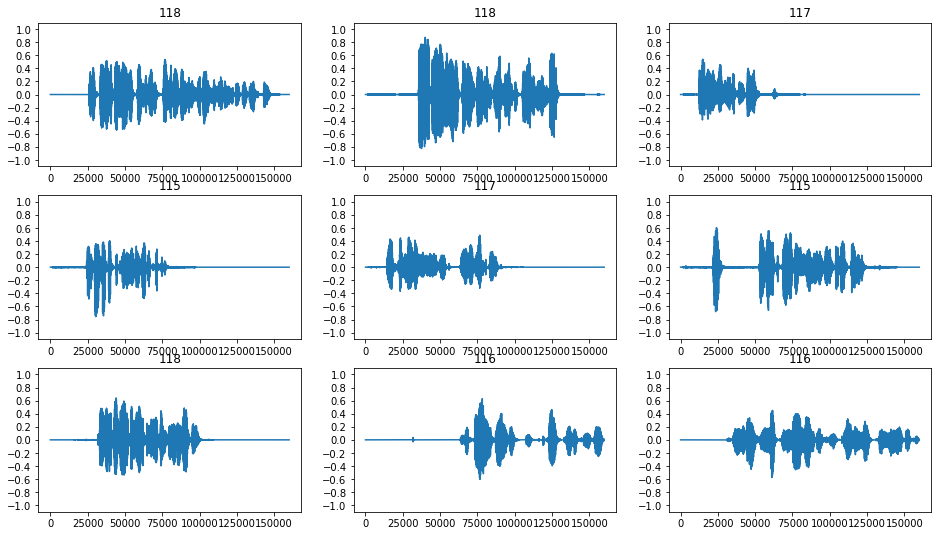

In [77]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [78]:
def get_spectrogram(waveform):
      # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [81]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=2*16000))

Label: 118
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Label: 118
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Label: 117
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


In [82]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)




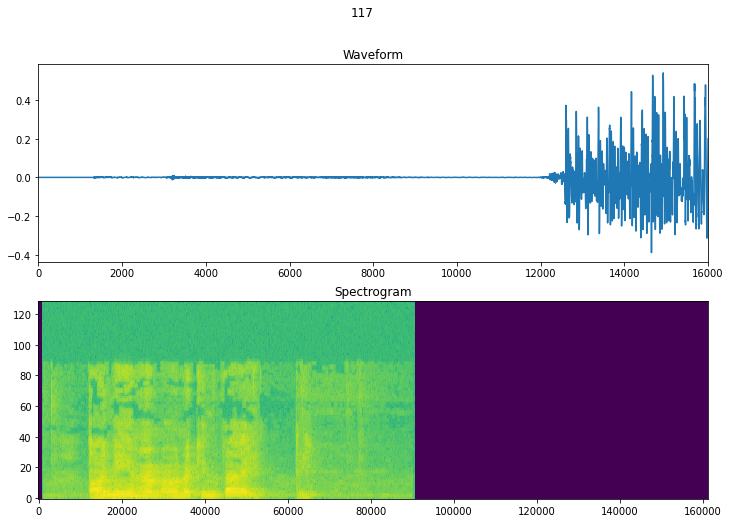

In [83]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


In [85]:
def make_spec_ds(ds):
      return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [86]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


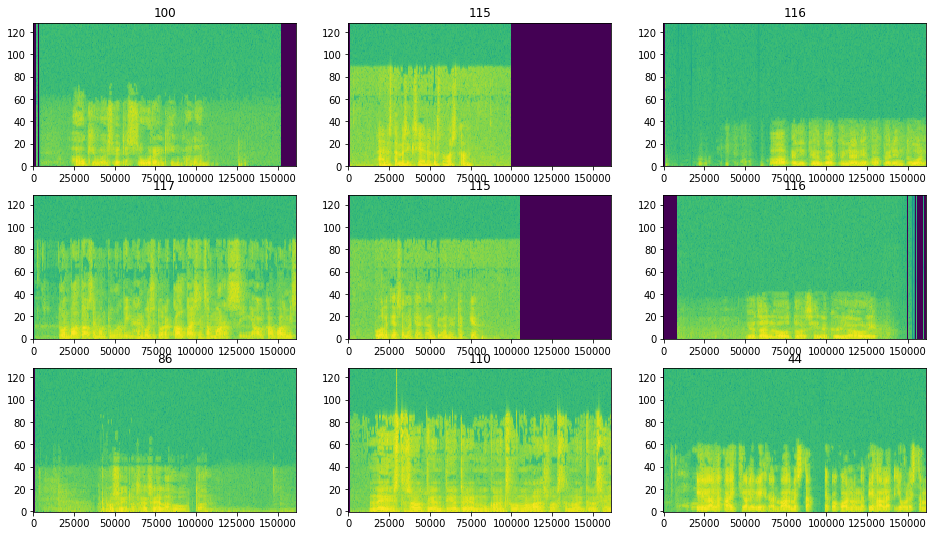

In [88]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()


In [89]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


In [110]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(
    map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (1249, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)      

In [91]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [92]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/10
87/87 [==============================] - 7s 73ms/step - loss: 2.9008 - accuracy: 0.4190 - val_loss: 2.2047 - val_accuracy: 0.5485
Epoch 2/10
87/87 [==============================] - 5s 52ms/step - loss: 2.2223 - accuracy: 0.5353 - val_loss: 1.9296 - val_accuracy: 0.6118
Epoch 3/10
87/87 [==============================] - 5s 52ms/step - loss: 1.9749 - accuracy: 0.5738 - val_loss: 1.7254 - val_accuracy: 0.6368
Epoch 4/10
87/87 [==============================] - 5s 52ms/step - loss: 1.7515 - accuracy: 0.6034 - val_loss: 1.5733 - val_accuracy: 0.6544
Epoch 5/10
87/87 [==============================] - 4s 51ms/step - loss: 1.5762 - accuracy: 0.6360 - val_loss: 1.4393 - val_accuracy: 0.6632
Epoch 6/10
87/87 [==============================] - 4s 51ms/step - loss: 1.4165 - accuracy: 0.6625 - val_loss: 1.2910 - val_accuracy: 0.7103
Epoch 7/10
87/87 [==============================] - 5s 52ms/step - loss: 1.2651 - accuracy: 0.6883 - val_loss: 1.1513 - val_accuracy: 0.7294
Epoch 8/10
87

Text(0, 0.5, 'Accuracy [%]')

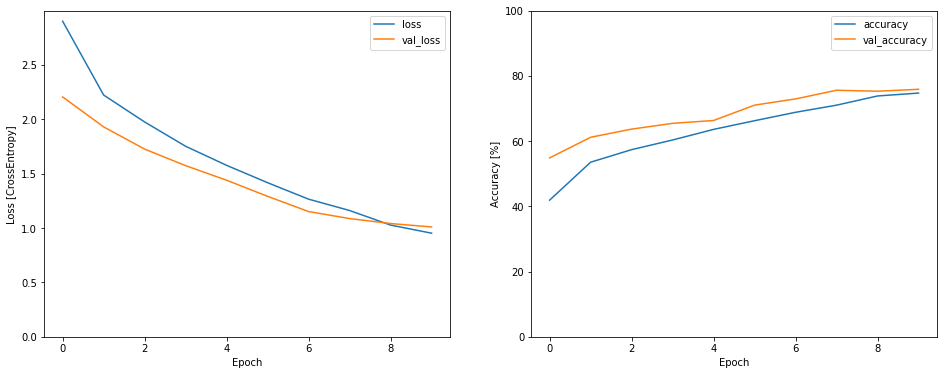

In [93]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 *
         np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


In [94]:
model.evaluate(test_spectrogram_ds, return_dict=True)


11/11 [==============================] - 2s 37ms/step - loss: 1.0582 - accuracy: 0.7557


{'loss': 1.0581861734390259, 'accuracy': 0.7556818127632141}

In [95]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

11/11 [==============================] - 0s 9ms/step


In [98]:
#confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
#plt.figure(figsize=(100, 80))
#sns.heatmap(confusion_mtx,
#            xticklabels=label_names,
#            yticklabels=label_names,
#            annot=True, fmt='g')
#plt.xlabel('Prediction')
#plt.ylabel('Label')
#plt.show()


In [131]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        # Accept either a string-filename or a batch of waveforms.
        # YOu could add additional signatures for a single wave, or a ragged-batch. 
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=[None, 10*16000], dtype=tf.float32))


    @tf.function
    def __call__(self, x):
    # If they pass a string, load the file and decode it. 
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]

        x = get_spectrogram(x)  
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions':result,
                'class_ids': class_ids,
                'class_names': class_names}

In [132]:
export = ExportModel(model)
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])


INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


{'predictions': <tf.Tensor: shape=(1, 119), dtype=float32, numpy=
 array([[-0.015225  , -0.00062817, -0.0224102 , -0.06500342,  0.00211097,
          0.03833714, -0.06754413,  0.04297148,  0.08789727,  0.03716104,
          0.01305715, -0.0372858 ,  0.05707507, -0.01456483,  0.02359609,
          0.01502784,  0.01647401,  0.09483925, -0.03958831,  0.04762654,
          0.08069402,  0.07598001, -0.04801422, -0.0276193 ,  0.03369905,
         -0.02356353,  0.08181755,  0.05537387, -0.01797357, -0.05524392,
          0.00758244, -0.05708686, -0.03551295,  0.00135683,  0.02034769,
         -0.01663925, -0.00654194, -0.01631704, -0.07351518,  0.02344982,
         -0.04950833,  0.05032387,  0.00434104,  0.00558603,  0.03039657,
         -0.00838727, -0.04078274, -0.04170301, -0.07200819, -0.02014562,
         -0.01285   , -0.06636379,  0.05616   , -0.0761897 , -0.05242652,
          0.0100433 , -0.03454047,  0.02864869,  0.0386637 , -0.0106946 ,
         -0.05427227, -0.04163202,  0.04265055